## Seasonal ARIMA

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
df = pd.read_csv('data/portland-oregon-average-monthly-.csv')
df

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630
...,...,...
110,1969-03,1419
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327


In [29]:
df.drop(114, inplace=True)
df

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630
...,...,...
109,1969-02,1425
110,1969-03,1419
111,1969-04,1432
112,1969-05,1394


In [30]:
# Correct the dates and set as index
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['Month'] =date_list
df.set_index(['Month'], inplace=True)
df.index.name=None
df.columns= ['riders']

In [31]:
df.head()

,riders
1973-01-01,648
1973-02-01,646
1973-03-01,639
1973-04-01,654
1973-05-01,630


In [32]:
df['riders'] = df.riders.apply(lambda x: int(x)*100)
df.head()

,riders
1973-01-01,64800
1973-02-01,64600
1973-03-01,63900
1973-04-01,65400
1973-05-01,63000


### Visualization

First, lets check for any seasonality in the data.

<AxesSubplot:title={'center':'Monthly Ridership'}>

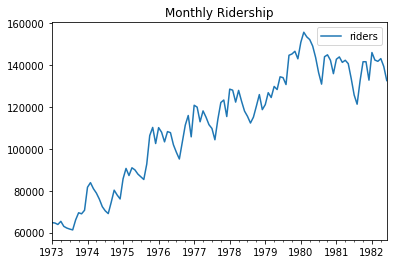

In [7]:
df.plot(title= 'Monthly Ridership')

There is an upward trend and seasonality. Further explore it with `seasonal_decompose` function in `statsmodel`.

<Figure size 432x288 with 0 Axes>

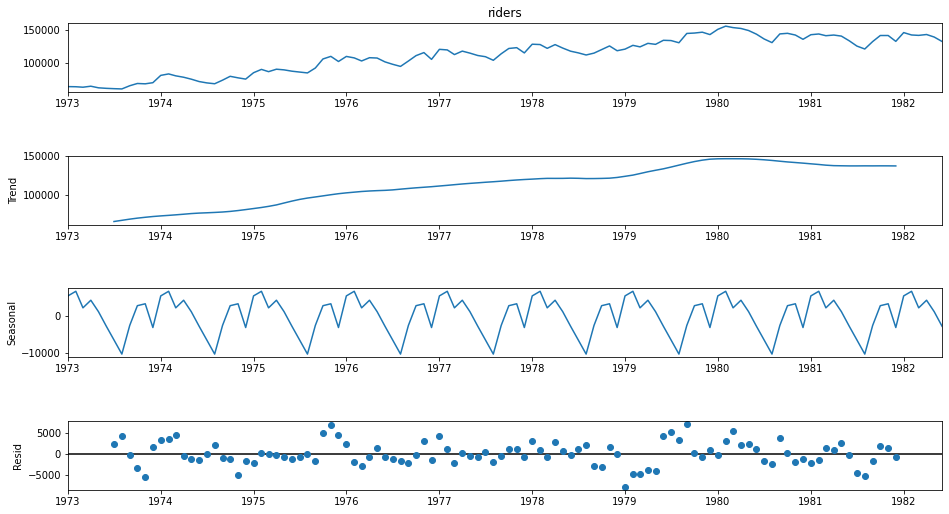

In [33]:
decomposition = seasonal_decompose(df.riders, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Stationarize the data:

#### What is stationary data
* The mean of the series should not be a function of time.
* The variance of the series should not be a function of time. 
* The covariance of the i th term and the (i + m) th term should not be a function of time.

**Need for stationarizing data**
When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

Dickey-Fuller test can be used to check whether the data is stationary. If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary.

In [34]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

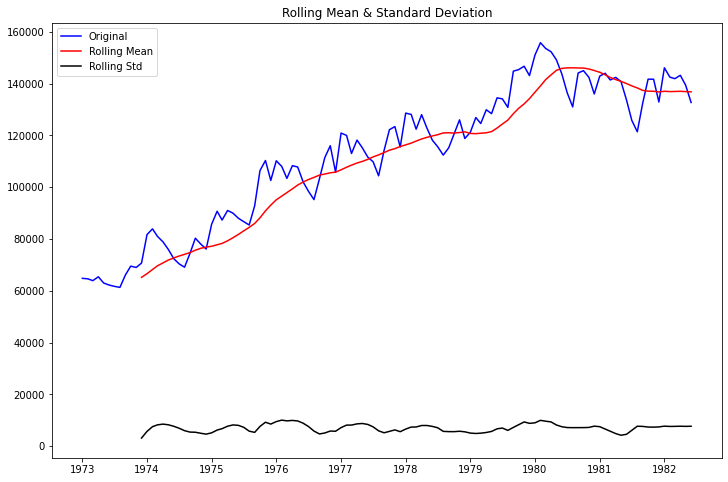

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [35]:
test_stationarity(df.riders)

So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data.

1. Deflation by CPI
2. Logarithmic
3. First Difference
4. Seasonal Difference
5. Seasonal Adjustment

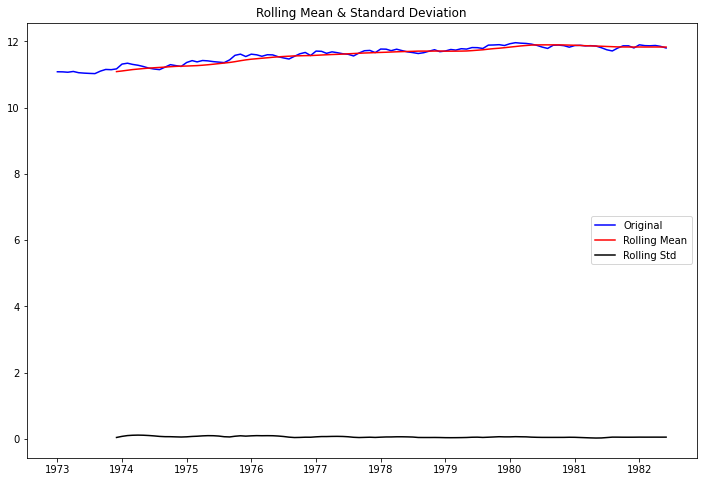

Results of Dickey-Fuller Test:
Test Statistic                  -1.677830
p-value                          0.442570
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [36]:
df['riders_log']= df.riders.apply(lambda x: np.log(x))  
test_stationarity(df.riders_log)

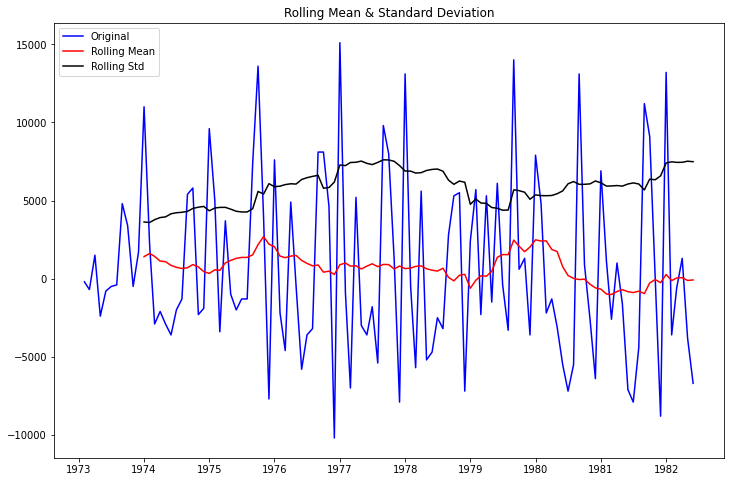

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [37]:
df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

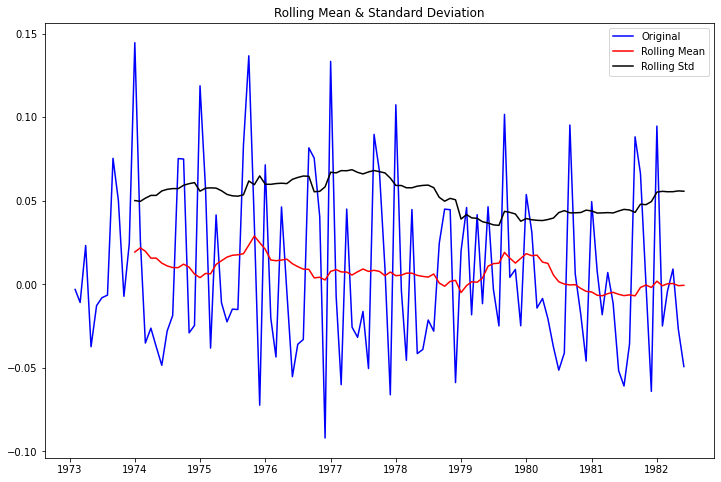

Results of Dickey-Fuller Test:
Test Statistic                  -2.047539
p-value                          0.266126
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [38]:
df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)  
test_stationarity(df.log_first_difference.dropna(inplace=False))

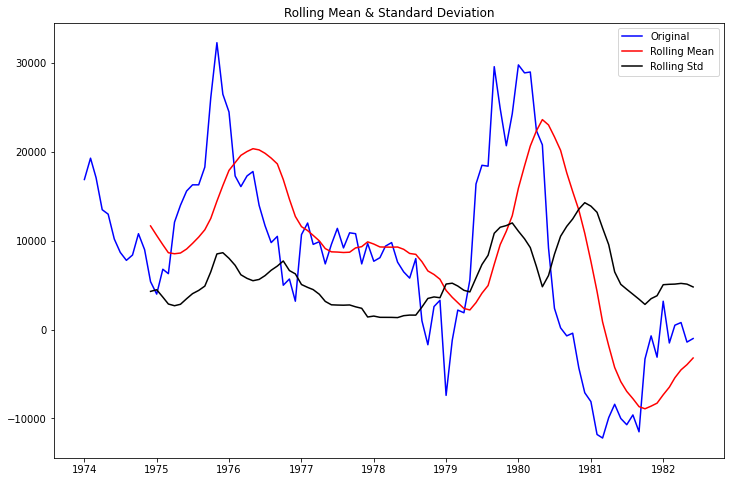

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [39]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

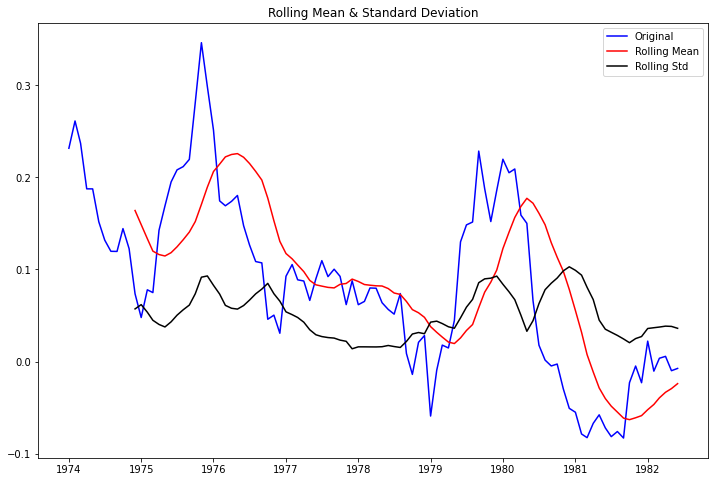

Results of Dickey-Fuller Test:
Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [40]:
df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)  
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))

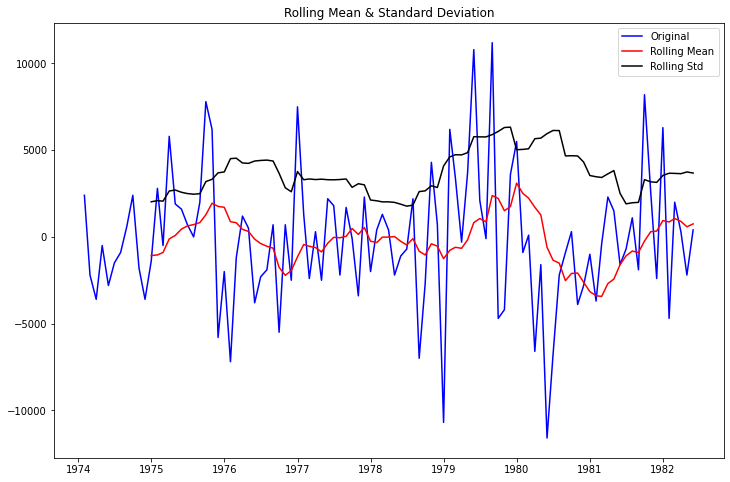

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [41]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

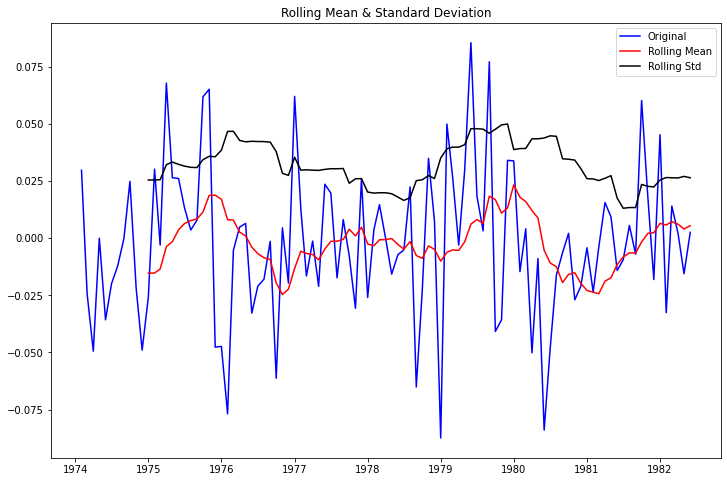

Results of Dickey-Fuller Test:
Test Statistic                -8.882112e+00
p-value                        1.309452e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [42]:
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)  
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))

Now, the p-value has confirmed that our data is stationary.

### Plot the ACF and PACF charts and find the optimal parameters

The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many rules and best practices about how to select the appropriate AR, MA, SAR, and MAR terms for the model. The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs to select the proper terms. 



C:\Users\tresa\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


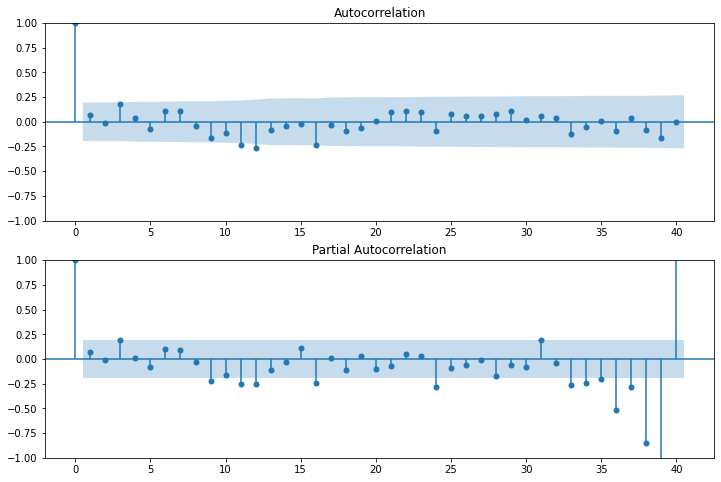

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=axes[1])

### Build Model:

In [19]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -976.135
Date:                              Mon, 17 Jan 2022   AIC                           1956.271
Time:                                      15:41:50   BIC                           1961.501
Sample:                                  01-01-1973   HQIC                          1958.388
                                       - 06-01-1982                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1377      0.050     -2.757      0.006      -0.236      -0.040
sigma2      1.424e+

C:\Users\tresa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tresa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [20]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

C:\Users\tresa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tresa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                               riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -970.257
Date:                              Mon, 17 Jan 2022   AIC                           1946.514
Time:                                      15:41:51   BIC                           1954.359
Sample:                                  01-01-1973   HQIC                          1949.690
                                       - 06-01-1982                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.99

### Make predictions

<AxesSubplot:>

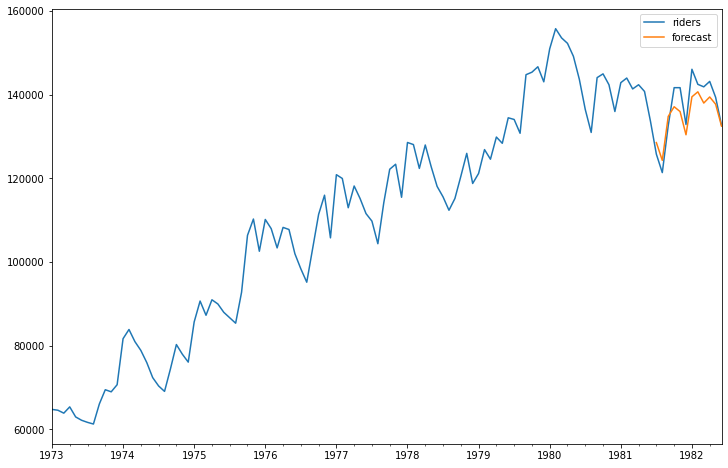

In [21]:
df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(12, 8)) 

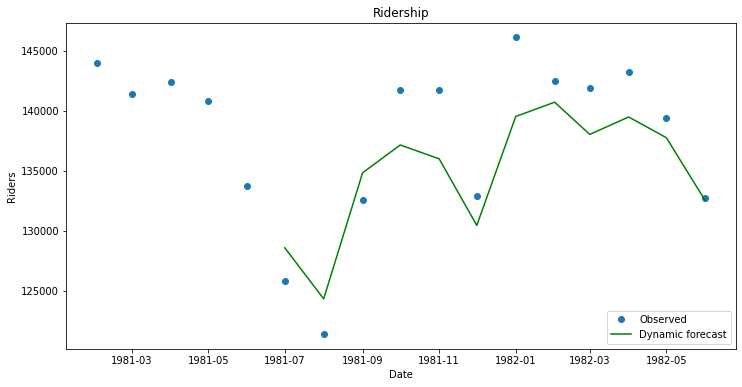

In [22]:
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.iloc[-npredict-npre+1:, 0], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.iloc[-npredict-npre+1:, -1], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [23]:
# To generate future forecasts, first add new time periods to the data frame.
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

<AxesSubplot:>

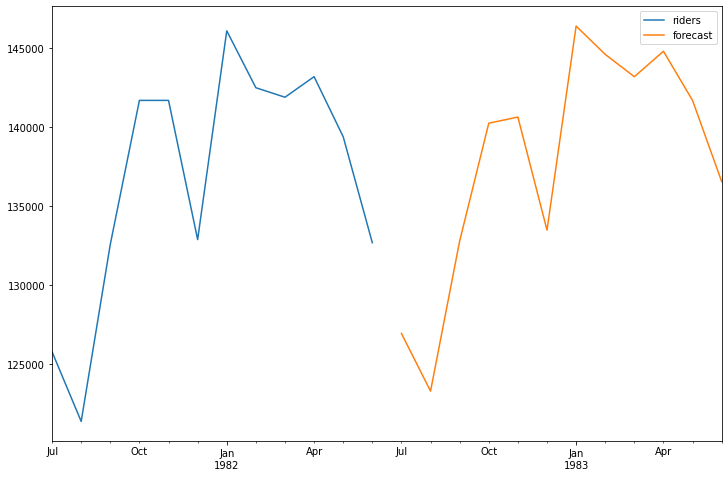

In [24]:
df['forecast'] = results.predict(start = 114, end = 125, dynamic= True)  
df[['riders', 'forecast']].iloc[-24:].plot(figsize=(12, 8)) 
